In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings('ignore')

## Funções

In [2]:
def aux(df):
    
    
    '''
    in: DataFrame;
    out: DataFrame auxiliar
    '''
    
    
    df_aux = pd.DataFrame({'colunas' : df.columns,
                    'tipo': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unicos': df.nunique()})
    df_aux['percentual%'] = round(df_aux['missing'] / df_aux['size'],3)*100

    
    return df_aux



def plot_bars(df, features, n_rows, n_cols, title, figsize):
   

    fig = plt.figure(figsize=figsize)
    for i, feat in enumerate(features):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        sns.countplot(data=df, x=feat, ax=ax)
    
    fig.suptitle(title)
    fig.show()
    
    
    
def boruta_selector(df, y=None):
    
    
    Y = df[y]
    df = df.drop(y,axis=1)

    num_feat = df.select_dtypes(include=['int64','float64']).columns.tolist()
    pipe_num_tree = Pipeline(steps= [('imputer',SimpleImputer(strategy = 'median'))])
    preprocessor_tree = ColumnTransformer(transformers = [('num_preprocessor',pipe_num_tree, num_feat)])
    
    RF  = Pipeline(steps = [('preprocessor_rf', preprocessor_tree),('model_rf', RandomForestClassifier(random_state = 123 ,max_depth =5))])
    
    X = preprocessor_tree.fit_transform(df)
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)    

    feat_selector = BorutaPy(rf, n_estimators='auto',random_state=123, max_iter = 100) #500 iterações até convergir
    feat_selector.fit(X,Y)
    # Terceiro filtro com as features selecionadas pelo boruta
    cols_drop_boruta= [not x for x in feat_selector.support_.tolist()] #invertendo o vetor de true/false
    cols_drop_boruta= df.loc[:,cols_drop_boruta].columns.tolist()
    
    
    return cols_drop_boruta



def get_IV(df, target):
    
    lst = []
    temp = df.drop(target, axis=1).columns
    results = pd.DataFrame()
    
    for feature in tqdm(temp):
        unique_values = df[feature].unique()
        for val in unique_values:
            lst.append([feature,                                                        
                        val,                                                            
                        df[(df[feature] == val) & (df[target] == 0)].count()[feature],  
                        df[(df[feature] == val) & (df[target] == 1)].count()[feature]   
                       ])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

    total_bad = df[df[target] == 1].count()[feature]
    total_good = df.shape[0] - total_bad

    data['Distribution Good'] = data['Good']/ total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    results = results.append(data, ignore_index=True)


    return results

## Sumário

1. [Ingestão dos dados](#ingestion)
2. [Exploração dos dados](#explo)
3. [Feature Select](#featselect)
4. [Imputação de dados faltantes](#imp)
5. [Salvando bases](#save)
6. [Considerações](#feateng)

## Ingestão dos dados

In [3]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_INTER_TRAIN_NAME = 'df_train.csv'
DATA_RAW_TEST_NAME = 'teste.csv'
DATA_PROCE_TRAIN_NAME = 'df_train.csv'
DATA_PROCE_TEST_NAME = 'df_test.csv'
DATA_INTER_PATH = os.path.join('..','data','interim')
DATA_INTER_PROCESSED = os.path.join('..', 'data', 'processed')
IMG_PATH = os.path.abspath(os.path.join('..','reports', 'figures'))

In [4]:
train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME))
test = pd.read_csv(os.path.join(DATA_RAW_PATH, DATA_RAW_TEST_NAME))
train.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0


## Exploração dos dados

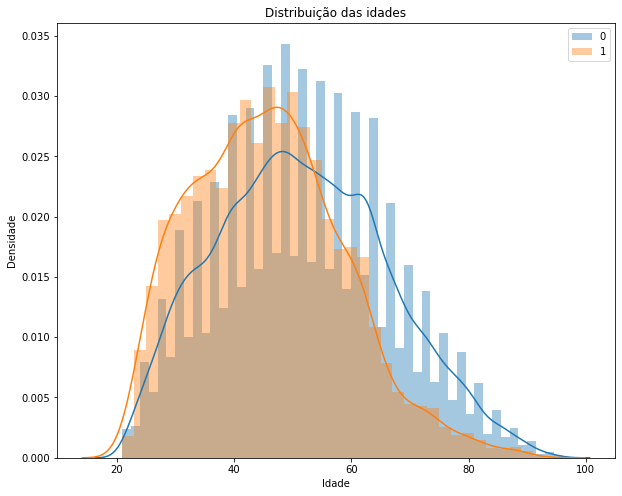

In [5]:
plt.figure(figsize = (10, 8))

sns.distplot(train.loc[train['inadimplente'] == 0, 'idade'], label='0')
sns.distplot(train.loc[train['inadimplente'] == 1, 'idade'], label='1')

plt.legend()
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição das idades')

plt.savefig(os.path.join(IMG_PATH,'dist-idades.png'), format='png')

In [6]:
print('idade mínima:', train.idade.min())
print('idade máxima:', train.idade.max())

idade mínima: 21
idade máxima: 96


In [7]:
idade = train[['inadimplente', 'idade']]
idade['idade_bin'] = pd.cut(idade['idade'], bins=np.linspace(20, 110, num=10))
idade_grupo = idade.groupby('idade_bin').mean()

In [8]:
idade_grupo

,inadimplente,idade
idade_bin,,
"(20.0, 30.0]",0.116130,27.055173
"(30.0, 40.0]",0.093023,35.838437
"(40.0, 50.0]",0.082540,45.679161
"(50.0, 60.0]",0.064588,55.332770
"(60.0, 70.0]",0.037485,64.814458
"(70.0, 80.0]",0.026316,74.884118
"(80.0, 90.0]",0.023213,84.366760
"(90.0, 100.0]",0.010309,92.494845
"(100.0, 110.0]",NaN,NaN


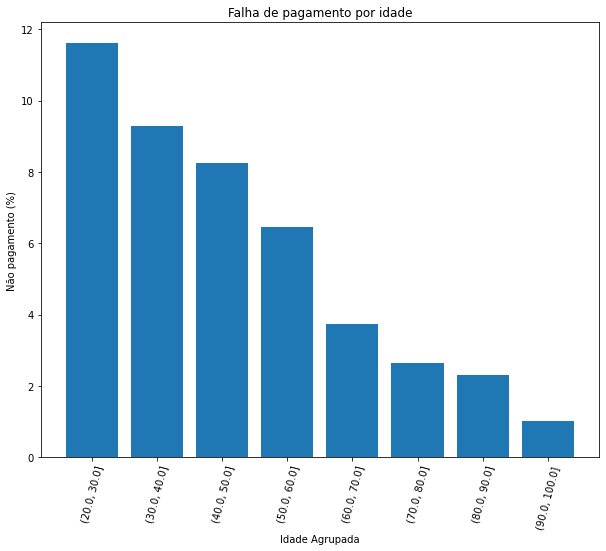

In [9]:
plt.figure(figsize = (10, 8))

plt.bar(idade_grupo.index.astype(str), 100 * idade_grupo['inadimplente'])

plt.xticks(rotation = 75)
plt.xlabel('Idade Agrupada')
plt.ylabel('Não pagamento (%)')
plt.title('Falha de pagamento por idade')

plt.savefig(os.path.join(IMG_PATH,'falha-pagamento.png'), format='png')

Candidatos mais jovens tem maior probabilidade de não pagar. A taxa de inadimplência está acima de 10% para os dois grupos de idade mais jovens 20-30, 30-40.

Como os clientes mais jovens tem menos probabilidade de pagar o empréstimo, os bancos devem receber mais orientações ou dicas de planejamento financeiro para conceder o emprestimo para pessoas mais jovens.

In [10]:
train.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

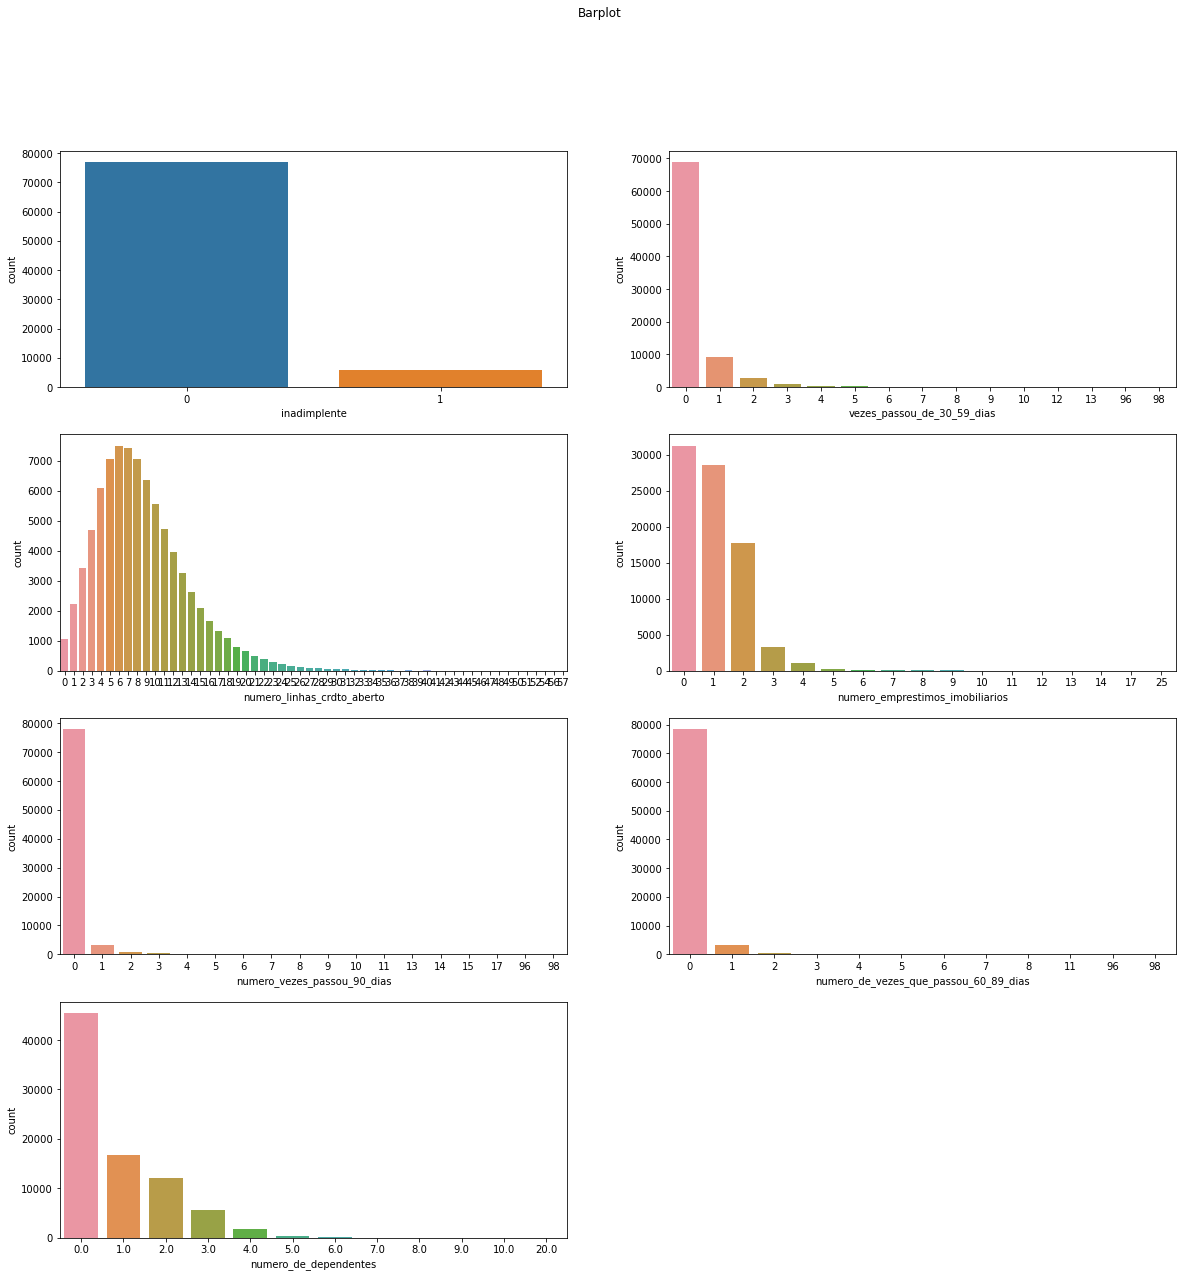

In [11]:
plot_bars(train, features=[
    'inadimplente', 
    'vezes_passou_de_30_59_dias', 
    'numero_linhas_crdto_aberto', 
    'numero_emprestimos_imobiliarios',
    'numero_vezes_passou_90_dias', 
    'numero_de_vezes_que_passou_60_89_dias', 
    'numero_de_dependentes'],
          n_rows=4, n_cols=2, title='Barplot', figsize=(20,20))

plt.savefig(os.path.join(IMG_PATH,'barplots.png'), format='png')

## Feature Select

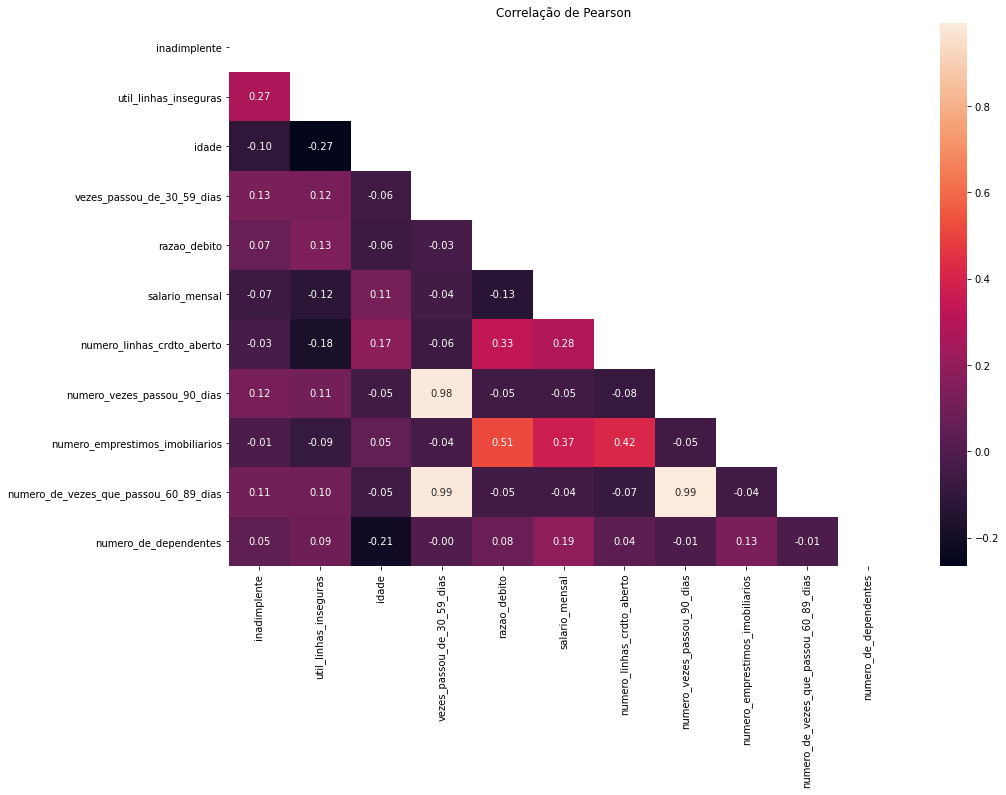

In [12]:
num_feat_corr = train.corr()
mask = np.triu(np.ones_like(num_feat_corr, dtype=np.bool))
plt.figure(figsize=(15, 10))
sns.heatmap(num_feat_corr, mask=mask,fmt='.2f', annot=True)
plt.title('Correlação de Pearson')

plt.savefig(os.path.join(IMG_PATH,'corr-pearson.png'), format='png')

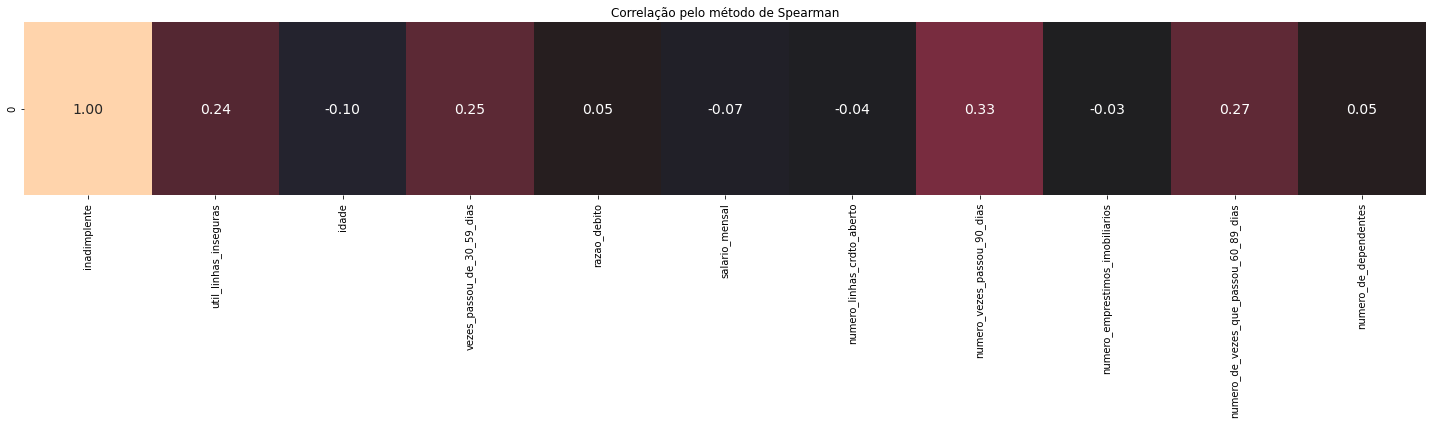

In [13]:
plt.figure(figsize=(20,6))
corrmat = train.corr(method='spearman')
sns.heatmap([corrmat['inadimplente']], xticklabels = corrmat.index,
            annot=True, fmt='.2f', annot_kws={'size': 14},
            cbar=False, center=0)
plt.title('Correlação pelo método de Spearman')

plt.savefig(os.path.join(IMG_PATH,'corr-spearman.png'), format='png')
plt.tight_layout()
plt.show()

In [14]:
lista_correlacao = abs(num_feat_corr['inadimplente'].sort_values(axis=0, ascending=False).iloc[1:])
lista_drop_corr = lista_correlacao[lista_correlacao < 0.01].index.tolist()

lista_drop_corr

[]

In [15]:
list_drop_boruta = boruta_selector(train, y='inadimplente')

list_drop_boruta

[]

In [16]:
iv_train = train.copy()
aux(iv_train)

,colunas,tipo,missing,size,unicos,percentual%
inadimplente,inadimplente,int64,0,82709,2,0.0
util_linhas_inseguras,util_linhas_inseguras,float64,0,82709,70390,0.0
idade,idade,int64,0,82709,76,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,82709,15,0.0
razao_debito,razao_debito,float64,0,82709,75609,0.0
salario_mensal,salario_mensal,float64,1055,82709,10722,1.3
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,82709,56,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,82709,18,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,82709,17,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,82709,12,0.0


In [17]:
iv_train['util_linhas_inseguras'] = pd.cut(x=iv_train.util_linhas_inseguras, bins=[-1, .2, .4, .6, .8, 1.5], labels=['pouco', 'pouco', 'media', 'muito', 'muito'], ordered=False)
iv_train['idade'] = pd.cut(x=iv_train.idade, bins=[19, 25, 40, 60, 75,120], labels=['ate_25', 'ate_40', 'ate_60', 'ate_75', 'mais_75'], ordered=False)
iv_train['vezes_passou_de_30_59_dias'] = pd.cut(x=iv_train.vezes_passou_de_30_59_dias, bins=[-1, 0, 5, 10, 100], labels=['n_passou', 'ate_5', 'ate_10' ,'mais_10'], ordered=False)
iv_train['razao_debito'] = pd.cut(x=iv_train.razao_debito, bins=[-1, .5, 0.7, 2], labels=['baixo', 'alto', 'muito_alto'], ordered=False)
iv_train['salario_mensal'] = pd.cut(x=iv_train.salario_mensal, bins=[-1, 0, 2090, 4180, 10450, 20900], labels=['sem_salario', 'E', 'D', 'C', 'B'], ordered=False)
iv_train['numero_linhas_crdto_aberto'] = pd.cut(x=iv_train.numero_linhas_crdto_aberto, bins=[-1, 0, 5, 10, 20, 60], labels=['sem_emprestimo', 'ate_5', 'ate_10', 'ate_20', 'mais_20'], ordered=False)
iv_train['numero_vezes_passou_90_dias'] = pd.cut(x=iv_train.numero_vezes_passou_90_dias, bins=[-1, 0, 5, 10, 100], labels=['n_passou', 'ate_5', 'ate_10' ,'mais_10'], ordered=False)
iv_train['numero_emprestimos_imobiliarios'] = pd.cut(x=iv_train.numero_emprestimos_imobiliarios, bins=[-1, 0, 5, 10, 30], labels=['sem_emprestimo', 'ate_5', 'ate_10', 'mais_10'], ordered=False)
iv_train['numero_de_vezes_que_passou_60_89_dias'] = pd.cut(x=iv_train.numero_de_vezes_que_passou_60_89_dias, bins=[-1, 0, 5, 10, 100], labels=['n_passou', 'ate_5', 'ate_10' ,'mais_10'], ordered=False)
iv_train['numero_de_dependentes'] = pd.cut(x=iv_train.numero_de_dependentes, bins=[-1, 0, 5, 10, 30], labels=['sem_dep', 'ate_5', 'ate_10', 'mais_10'], ordered=False)

In [18]:
aux(iv_train)

,colunas,tipo,missing,size,unicos,percentual%
inadimplente,inadimplente,int64,0,82709,2,0.0
util_linhas_inseguras,util_linhas_inseguras,category,0,82709,3,0.0
idade,idade,category,0,82709,5,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,category,0,82709,4,0.0
razao_debito,razao_debito,category,0,82709,3,0.0
salario_mensal,salario_mensal,category,1055,82709,5,1.3
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,category,0,82709,5,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,category,0,82709,4,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,category,0,82709,4,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,category,0,82709,4,0.0


In [19]:
results = get_IV(df=iv_train, target='inadimplente')

  0%|          | 0/10 [00:00<?, ?it/s]

* < 0.02 = useless for prediction
* 0.02 to 0.1 = weak predictor
* 0.1 to 0.3 = medium predictor
* 0.3 to 0.5 = strong predictor
* . > 0.5 = suspicious or too good to be true

In [20]:
results.groupby(by=['Variable'])[['WoE', 'IV']].sum().sort_values(by='IV', ascending=False)

,WoE,IV
Variable,,
util_linhas_inseguras,-0.192947,0.897586
numero_vezes_passou_90_dias,-7.881402,0.786119
vezes_passou_de_30_59_dias,-6.125981,0.653288
numero_de_vezes_que_passou_60_89_dias,-8.892838,0.535468
idade,0.852149,0.181790
numero_linhas_crdto_aberto,-1.567593,0.092049
razao_debito,-0.708982,0.070423
salario_mensal,0.003500,0.061293
numero_emprestimos_imobiliarios,-3.080615,0.043368


In [21]:
lista_iv = results.groupby(by=['Variable'])[['WoE', 'IV']].sum()['IV'].sort_values(axis=0, ascending=False)
lista_drop_iv = lista_iv[lista_iv < 0.02].index.tolist()
lista_drop_iv

[]

## Imputação de dados faltantes

In [22]:
aux(train)

,colunas,tipo,missing,size,unicos,percentual%
inadimplente,inadimplente,int64,0,82709,2,0.0
util_linhas_inseguras,util_linhas_inseguras,float64,0,82709,70390,0.0
idade,idade,int64,0,82709,76,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,82709,15,0.0
razao_debito,razao_debito,float64,0,82709,75609,0.0
salario_mensal,salario_mensal,float64,1055,82709,10722,1.3
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,82709,56,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,82709,18,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,82709,17,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,82709,12,0.0


In [23]:
aux(test)

,colunas,tipo,missing,size,unicos,percentual%
util_linhas_inseguras,util_linhas_inseguras,float64,0,40000,34211,0.0
idade,idade,int64,0,40000,81,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,40000,14,0.0
razao_debito,razao_debito,float64,0,40000,33800,0.0
salario_mensal,salario_mensal,float64,7968,40000,7879,19.9
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,40000,52,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,40000,18,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,40000,21,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,40000,10,0.0
numero_de_dependentes,numero_de_dependentes,float64,1046,40000,12,2.6


### Treino

In [24]:
imp = train[['salario_mensal', 'idade']]
imp['idade_bin'] = pd.cut(imp['idade'], bins=np.linspace(20, 100, num=6))
imp = imp.groupby('idade_bin').mean()
imp

,salario_mensal,idade
idade_bin,,
"(20.0, 36.0]",4241.581858,30.675102
"(36.0, 52.0]",6373.426425,44.912196
"(52.0, 68.0]",6521.077708,59.799948
"(68.0, 84.0]",5316.469133,74.726903
"(84.0, 100.0]",4873.625850,87.917241


In [25]:
imp_2 = train[['numero_de_dependentes', 'idade']]
imp_2['idade_bin'] = pd.cut(imp_2['idade'], bins=np.linspace(20, 100, num=6))
imp_2 = imp_2.groupby('idade_bin').median()
imp_2

,numero_de_dependentes,idade
idade_bin,,
"(20.0, 36.0]",0.0,31
"(36.0, 52.0]",1.0,45
"(52.0, 68.0]",0.0,60
"(68.0, 84.0]",0.0,74
"(84.0, 100.0]",0.0,87


In [26]:
#TRAIN

#SALARIO
x = train[train['salario_mensal'].isna()]

r1 = x[(x.idade >= 20) & (x.idade < 36)][['salario_mensal']].fillna(imp['salario_mensal'][0])
r2 = x[(x.idade >= 36) & (x.idade < 52)][['salario_mensal']].fillna(imp['salario_mensal'][1])
r3 = x[(x.idade >= 52) & (x.idade < 68)][['salario_mensal']].fillna(imp['salario_mensal'][2])
r4 = x[(x.idade >= 68) & (x.idade < 84)][['salario_mensal']].fillna(imp['salario_mensal'][3])
r5 = x[(x.idade >= 84) & (x.idade < 100)][['salario_mensal']].fillna(imp['salario_mensal'][4])
train_salario_imp = pd.concat([r1,r2,r3,r4,r5])

#NUMERO DE DEPENDENTES
x = train[train['numero_de_dependentes'].isna()]

r1 = x[(x.idade >= 20) & (x.idade < 36)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][0])
r2 = x[(x.idade >= 36) & (x.idade < 52)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][1])
r3 = x[(x.idade >= 52) & (x.idade < 68)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][2])
r4 = x[(x.idade >= 68) & (x.idade < 84)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][3])
r5 = x[(x.idade >= 84) & (x.idade < 100)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][4])
train_ndepen_imp = pd.concat([r1,r2,r3,r4,r5])

#REPLACE
train.loc[train['salario_mensal'].isna(), 'salario_mensal'] = train_salario_imp['salario_mensal']
train.loc[train['numero_de_dependentes'].isna(), 'numero_de_dependentes'] = train_ndepen_imp['numero_de_dependentes']

In [27]:
aux(train)

,colunas,tipo,missing,size,unicos,percentual%
inadimplente,inadimplente,int64,0,82709,2,0.0
util_linhas_inseguras,util_linhas_inseguras,float64,0,82709,70390,0.0
idade,idade,int64,0,82709,76,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,82709,15,0.0
razao_debito,razao_debito,float64,0,82709,75609,0.0
salario_mensal,salario_mensal,float64,0,82709,10727,0.0
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,82709,56,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,82709,18,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,82709,17,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,82709,12,0.0


### Test

In [28]:
imp = test[['salario_mensal', 'idade']]
imp['idade_bin'] = pd.cut(imp['idade'], bins=np.linspace(20, 110, num=6))
imp = imp.groupby('idade_bin').mean()
imp

,salario_mensal,idade
idade_bin,,
"(20.0, 38.0]",4675.325865,31.867352
"(38.0, 56.0]",7505.612166,47.817925
"(56.0, 74.0]",7485.556859,64.042234
"(74.0, 92.0]",5089.296815,80.553325
"(92.0, 110.0]",4116.172414,95.032258


In [29]:
imp_2 = test[['numero_de_dependentes', 'idade']]
imp_2['idade_bin'] = pd.cut(imp_2['idade'], bins=np.linspace(20, 110, num=6))
imp_2 = imp_2.groupby('idade_bin').median()
imp_2

,numero_de_dependentes,idade
idade_bin,,
"(20.0, 38.0]",0.0,32
"(38.0, 56.0]",1.0,48
"(56.0, 74.0]",0.0,63
"(74.0, 92.0]",0.0,80
"(92.0, 110.0]",0.0,94


In [30]:
#TEST

#SALARIO
x = test[test['salario_mensal'].isna()]

r1 = x[(x.idade >= 20) & (x.idade < 36)][['salario_mensal']].fillna(imp['salario_mensal'][0])
r2 = x[(x.idade >= 36) & (x.idade < 52)][['salario_mensal']].fillna(imp['salario_mensal'][1])
r3 = x[(x.idade >= 52) & (x.idade < 68)][['salario_mensal']].fillna(imp['salario_mensal'][2])
r4 = x[(x.idade >= 68) & (x.idade < 84)][['salario_mensal']].fillna(imp['salario_mensal'][3])
r5 = x[(x.idade >= 84) & (x.idade < 110)][['salario_mensal']].fillna(imp['salario_mensal'][4])
test_salario_imp = pd.concat([r1,r2,r3,r4,r5])

#NUMERO DE DEPENDENTES
x = test[test['numero_de_dependentes'].isna()]

r1 = x[(x.idade >= 20) & (x.idade < 36)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][0])
r2 = x[(x.idade >= 36) & (x.idade < 52)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][1])
r3 = x[(x.idade >= 52) & (x.idade < 68)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][2])
r4 = x[(x.idade >= 68) & (x.idade < 84)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][3])
r5 = x[(x.idade >= 84) & (x.idade < 110)][['numero_de_dependentes']].fillna(imp_2['numero_de_dependentes'][4])
test_ndepen_imp = pd.concat([r1,r2,r3,r4,r5])

#REPLACE
test.loc[test['salario_mensal'].isna(), 'salario_mensal'] = test_salario_imp['salario_mensal']
test.loc[test['numero_de_dependentes'].isna(), 'numero_de_dependentes'] = test_ndepen_imp['numero_de_dependentes']

In [31]:
aux(test)

,colunas,tipo,missing,size,unicos,percentual%
util_linhas_inseguras,util_linhas_inseguras,float64,0,40000,34211,0.0
idade,idade,int64,0,40000,81,0.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,40000,14,0.0
razao_debito,razao_debito,float64,0,40000,33800,0.0
salario_mensal,salario_mensal,float64,0,40000,7884,0.0
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,40000,52,0.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,40000,18,0.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,40000,21,0.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,40000,10,0.0
numero_de_dependentes,numero_de_dependentes,float64,0,40000,12,0.0


## Salvando bases

In [32]:
train.to_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_TRAIN_NAME), index=False)
test.to_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_TEST_NAME), index=False)

## Considerações

* Nosso **target** encontra-se desbalanceado;
* Clientes mais jovens tendem a ser inadimplentes;
* Todas as variáveis tem importância para prever o target;
* Houve imputação de dados (média e mediana) baseado em faixas de idade.